# DECISION TREES

We are going to stick to Scikit-Learn here.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression). 

Let's create something to learn:

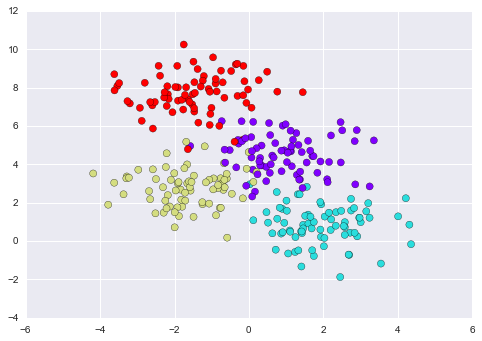

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Now we import our Decision Tree classifier from sklearn.tree (very familiar syntax!) and fit it using the fit method.

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X,y)

To see what's going on visually with the classification, we can use this (complex) visualizer. 

In [6]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [7]:
Xnew, ynew = make_blobs(n_samples=1000, centers=4,
                random_state=0, cluster_std=1.0)

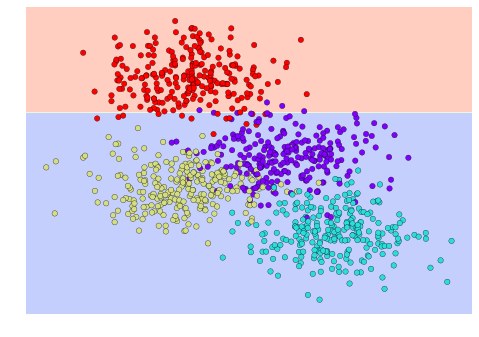

In [8]:
visualize_classifier(DecisionTreeClassifier(max_depth=1,random_state=0), Xnew, ynew, X, y) #We train on the full data

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_score(ynew,DecisionTreeClassifier(max_depth=10,random_state=0).fit(X,y).predict(Xnew))

0.91400000000000003

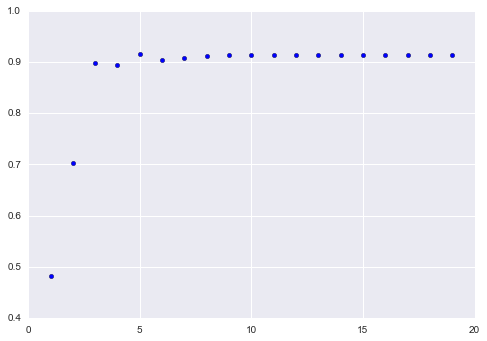

In [11]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X,y)
    score = accuracy_score(ynew,tree2.predict(Xnew))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec);

Near the cluster boundaries, the shape is pretty weird. Overfitting!

In [12]:
from sklearn.cross_validation import train_test_split #Can use this to split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5,random_state=1) #test_size means a 50/50 split
print(len(X))
print(len(Xtrain))
print(len(Xtest))


300
150
150


/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


With some abuse of notation, we can use the visualizer to plot first a classifier trained on the "training" half of the data.

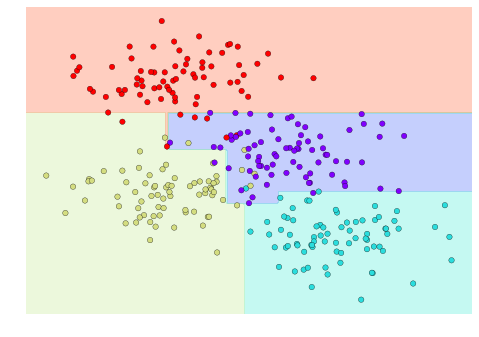

In [13]:
visualize_classifier(DecisionTreeClassifier(max_depth=5,random_state=0), X, y, Xtrain, ytrain) #Train with half the data

Now we can train on the second half of the data--allegedly the test data--to see how different training sets affect the decision boundaries.

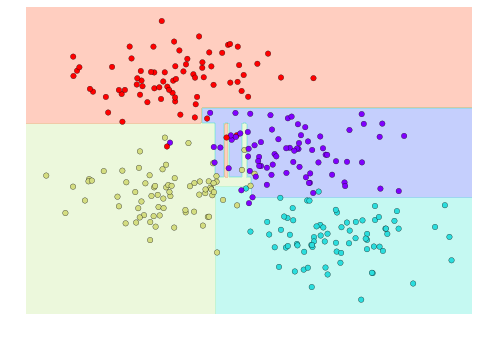

In [14]:
visualize_classifier(DecisionTreeClassifier(random_state=0), X, y, Xtest, ytest) #Train with other half of the data

Finally, we can get a sense of the performance by training on the training data, but PLOTTING the test data

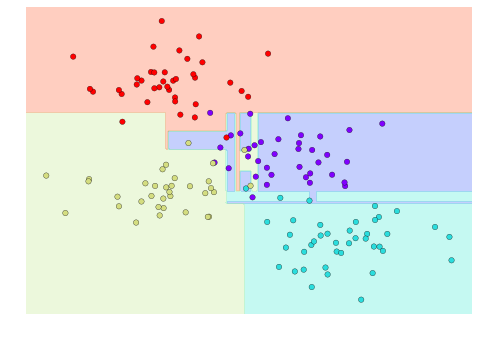

In [15]:
visualize_classifier(DecisionTreeClassifier(), Xtest, ytest, Xtrain, ytrain) #Trains with train data, plots test data

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [16]:
from sklearn.tree import DecisionTreeClassifier  #Just in case
from sklearn.ensemble import BaggingClassifier #The bagging

tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [17]:
?BaggingClassifier #Learn more

In [18]:
bag.fit(X,y) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [19]:
Xnew, ynew = make_blobs(n_samples=10000, centers=4,
                random_state=0, cluster_std=1.0)

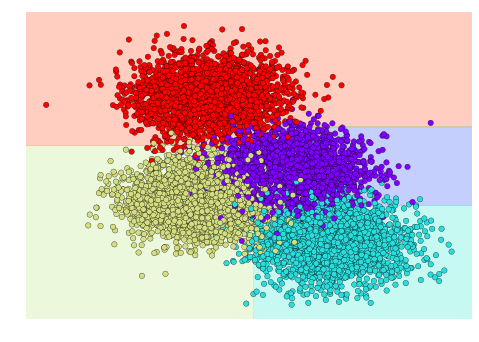

In [20]:
visualize_classifier(bag,Xnew,ynew,X,y) #And visualize
#Remember we can give the full data as training data, as bag automatically splits and trains

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
recall_score(ynew,bag.predict(Xnew),average='weighted')

0.9204

## Brief aside: Random forest regression

First, let's create a challenging dataset.

In [22]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200) #200 uniformly distributed random numbers between 0 and 10
def model(x, sigma=0.3): 
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x)) #Create 200 random numbers, normally distributed

    return slow_oscillation + fast_oscillation + noise

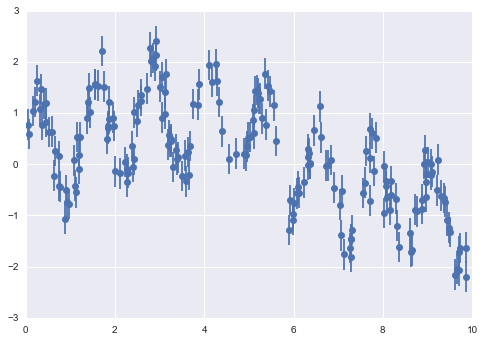

In [25]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); #Shows one std around point
#plt.scatter(x, y); #Plots the actual points

First we will try to learn this with something simple; a single decision tree, but one that is a regressor, not a classifier.

In [26]:
#First try to learn this with something simple --  a single decision tree regressor
from sklearn.tree import DecisionTreeRegressor

# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(x[:,None], y)
regr_2.fit(x[:,None], y)
regr_3.fit(x[:,None], y)

# Predict
xfit = np.linspace(0, 10, 1000)
yfit_1 = regr_1.predict(xfit[:, None]) #xfit[:,None] is a work-around to pass a 1d feature matrix
yfit_2 = regr_2.predict(xfit[:, None])
yfit_3 = regr_3.predict(xfit[:, None])

Let's see how these two decision trees do... What do you think will happen as we add depth?

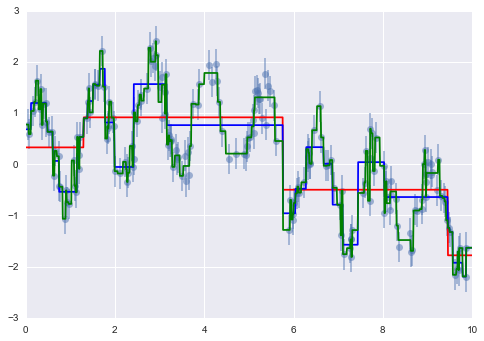

In [27]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit_1, '-r'); #depth = 2
plt.plot(xfit,yfit_2,'-b'); #depth = 5
plt.plot(xfit,yfit_3,'-g'); #depth = 10

Or we can use a **random forest regressor**

In [28]:
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)
    
yfit = forest.predict(xfit[:, None]) #Predictions of the forest model
ytrue = model(xfit, sigma=0) #This is the underlying data, no noise

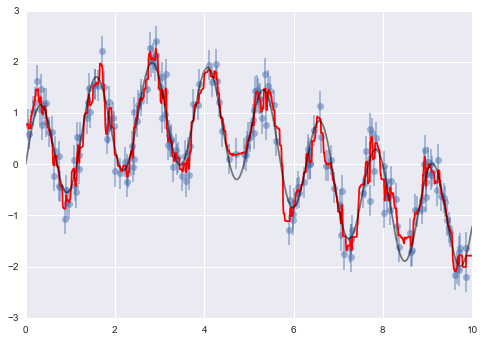

In [29]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

A beautiful fit of the underlying pattern... a lot of the noise has been washed out. This is the power of bagging.

# K-MEANS

Remember the basic goal of k-means: we want to partition our input data into a set of $k$ clusters, $\textbf{S} = \{S_1,\dots,S_k\}$ such that we minimize the sum of squared distances from each point in a cluster to the center of its assigned cluster, i.e., $\arg\min_S \sum_{i=1}^{k}\sum_{\textbf{x} \in S_i} \| \textbf{x} - \mathbf{\mu}_i \|^{2}$


We can approximately solve this using a very simple E-M (Expectation-Maximization) algorithm. The basic idea is:

1. Pick the number of clusters

2. Randomly choose initial cluster centers

3. Repeat until converged
    1. assign points to nearest cluster center (E-step)
    2. set the cluster centers to the mean (M-step) 

Here is one nearly "from scratch" implementation, from *The Python Data Science Handbook*

In [30]:
from sklearn.metrics import pairwise_distances_argmin #One little thing we'll import instead of writing up

def find_clusters(X, n_clusters, rseed=2): #STEP 1: Pick the number of clusters here; set the hyperparameter
    #STEP 2: Randomly choose initial cluster centers
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters] #X.shape[0] gives you the number of rows in the data, i.e. #points
    centers = X[i]
    
    while True: #STEP 3: Repeat until converged...
        # 3A. Assign labels based on closest center (E-step)
        labels = pairwise_distances_argmin(X, centers)
    
        # 3B. Find new centers from means of points (M-step)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) #This goes through all clusters and computes means.
        # 3C. Check for convergence
        if np.all(centers == new_centers): 
            break #Stop if converged
        centers = new_centers #otherwise use the new centers
    
    return centers, labels

Let's test it out!

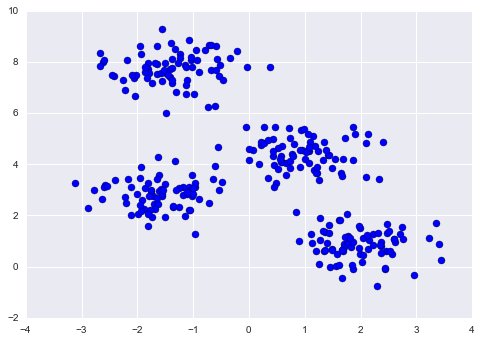

In [31]:
from sklearn.datasets.samples_generator import make_blobs 
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

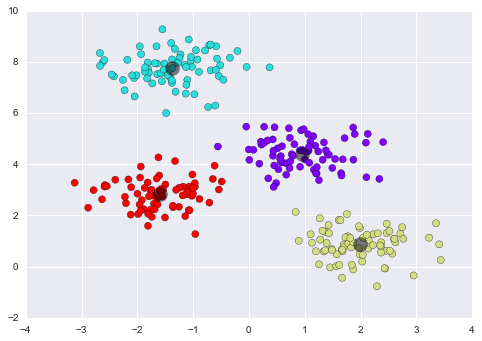

In [32]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='rainbow');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Of course there is a way to do this in Scikit-Learn:

In [33]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4) 
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's plot this!

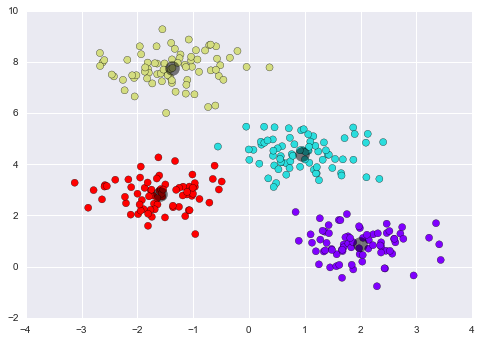

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers2 = kmeans.cluster_centers_
plt.scatter(centers2[:, 0],centers2[:, 1], c='black', s=200, alpha=0.5);

But there are some issues with E-M.

Issue 1) You may not find the global optimum, because this is a heuristic algorithm!

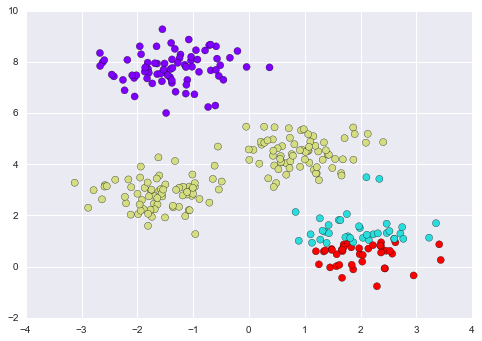

In [35]:
centers, labels = find_clusters(X, 4, rseed=0) #Set different seed, so it picks different starting points
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='rainbow');

Ugh! So you usually want to run this a few times. 

Issue 2. You have to select the number of clusters beforehand (i.e., it has a hyperparameter). K-means doesn't know how to learn the number of clusters from the data. For example...

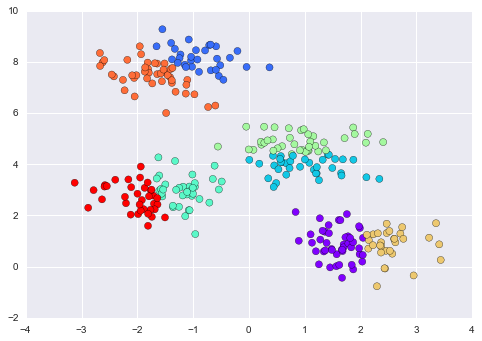

In [36]:
labels = KMeans(8, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='rainbow');

There are many ways to solve this; one of the simplest is called silhouette analysis. 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.542642229736


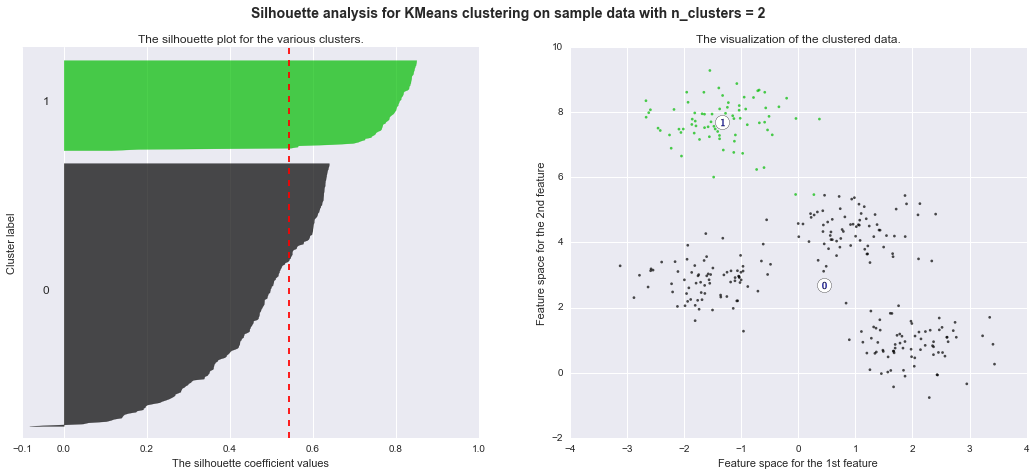

For n_clusters = 3 The average silhouette_score is : 0.589039039355


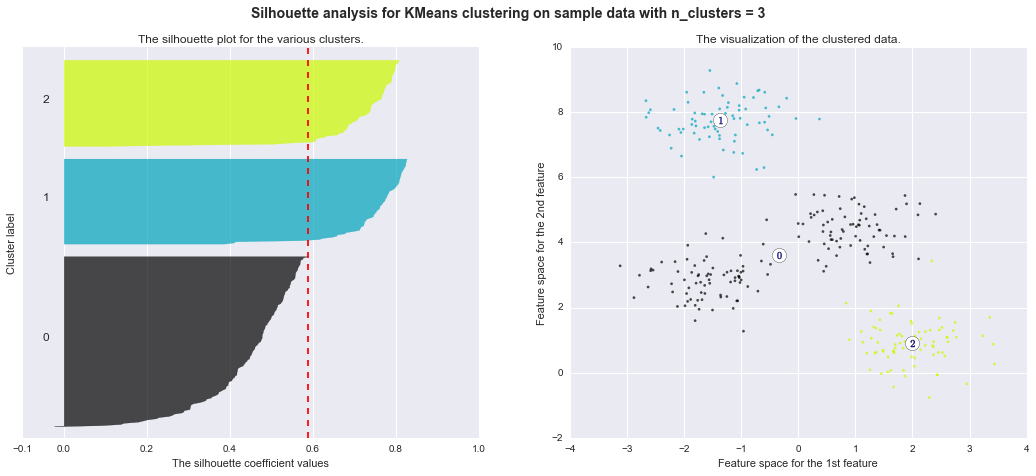

For n_clusters = 4 The average silhouette_score is : 0.681993869064


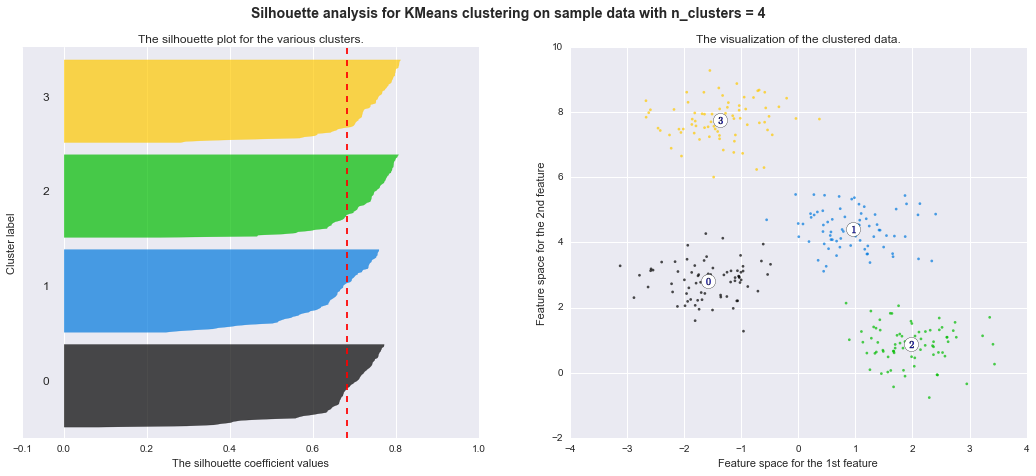

For n_clusters = 5 The average silhouette_score is : 0.592387514876


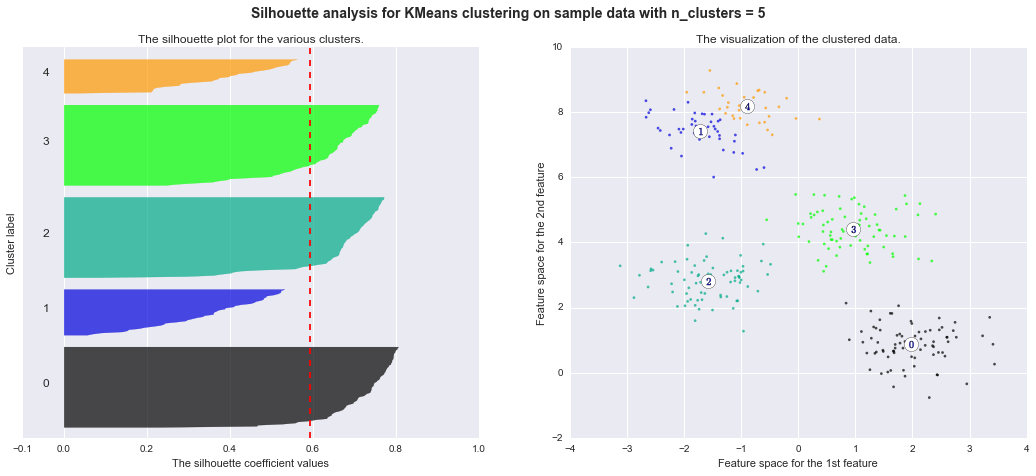

For n_clusters = 6 The average silhouette_score is : 0.499345044059


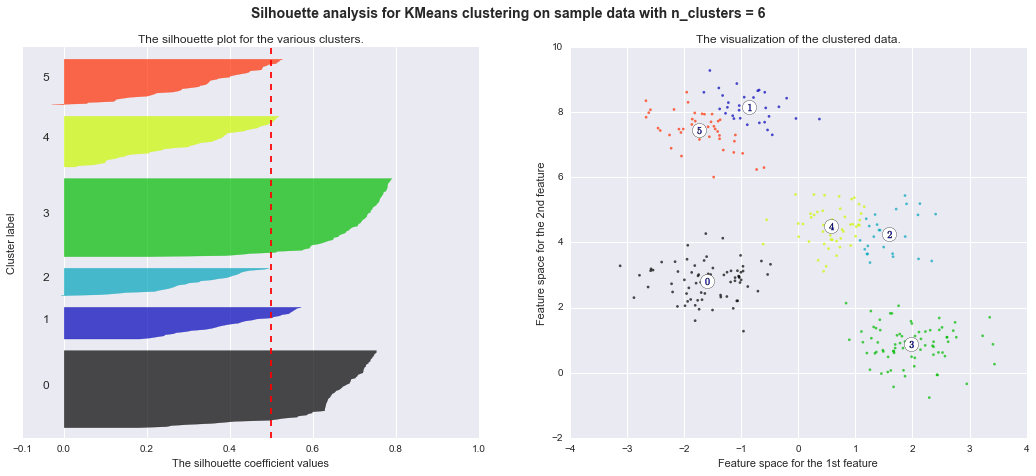

In [37]:
#See: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 
from __future__ import print_function

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distict cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Issue 3. It is also limited to linear cluster boundaries (this has to do with the cluster criterion). But we can easily find clusters that don't have linear boundaries...

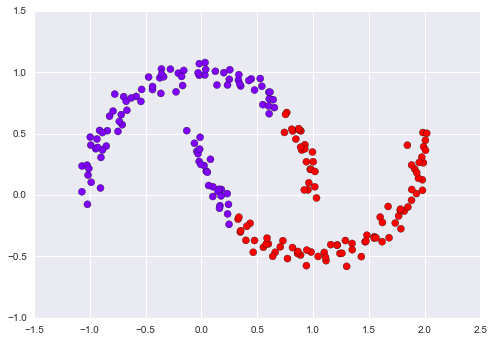

In [38]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='rainbow');

Remember that we often want to put data in a lower dimension; but sometimes putting data into a higher dimension can help. Using a *kernel transformation* we represent the data in higher dimensions, then use k-means. Scikit-Learn has a way to do this using Spectral Clustering.

/usr/local/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


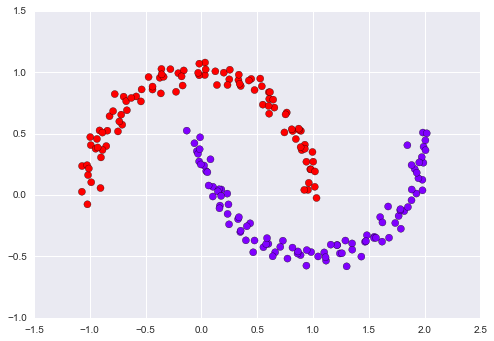

In [39]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='rainbow');

Can you do silhouette analysis on spectral clustering? I think yes?

Issue 4. k-means can be slow on big datasets (because we have to compute all those cluster distances and cluster averages at each step). There are ways to speed it up, e.g., by recomputing the centers from a random subset. This is called MiniBatch k-means. 

A fancier relative of k-means is the Gaussian Mixture Model. We will *probably* discuss that tomorrow.

Automatically created module for IPython interactive environment


/usr/local/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For n_clusters = 2 The average silhouette_score is : 0.325853189502


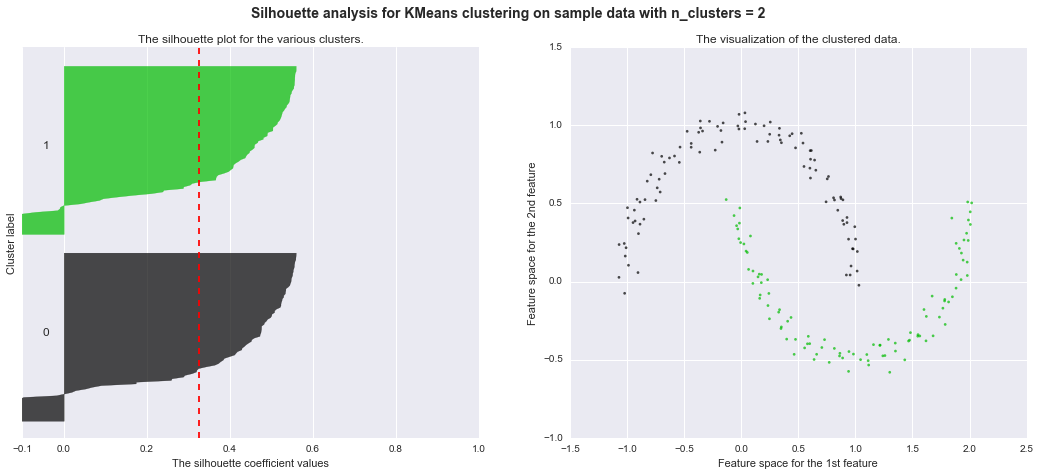

For n_clusters = 3 The average silhouette_score is : 0.325853189502


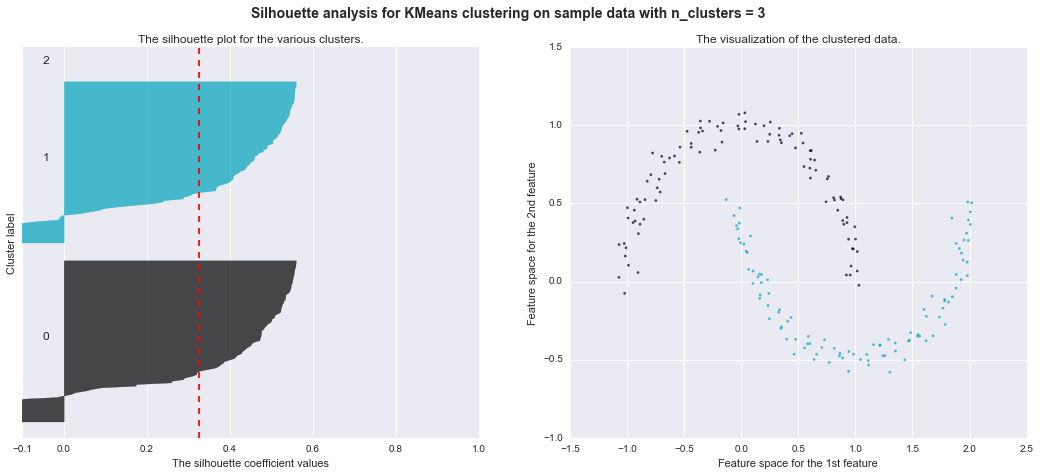

For n_clusters = 4 The average silhouette_score is : 0.325853189502


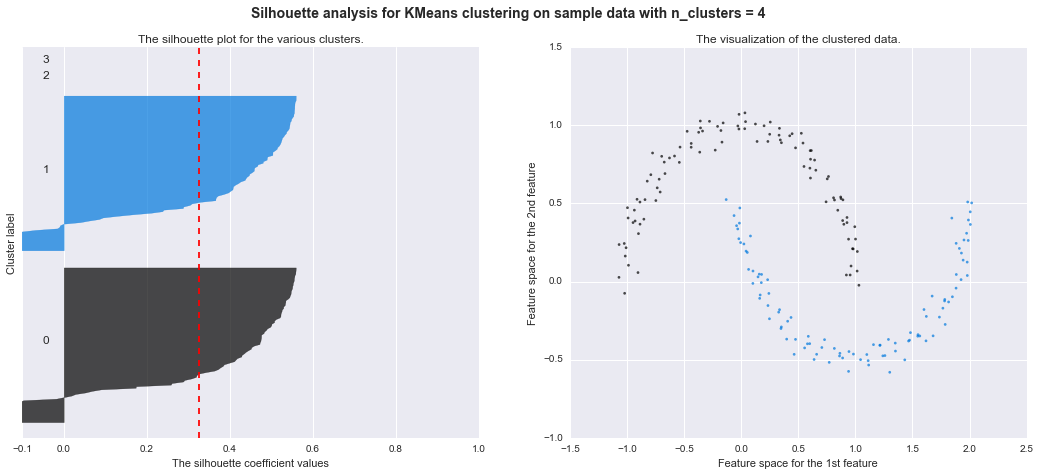

For n_clusters = 5 The average silhouette_score is : 0.325853189502


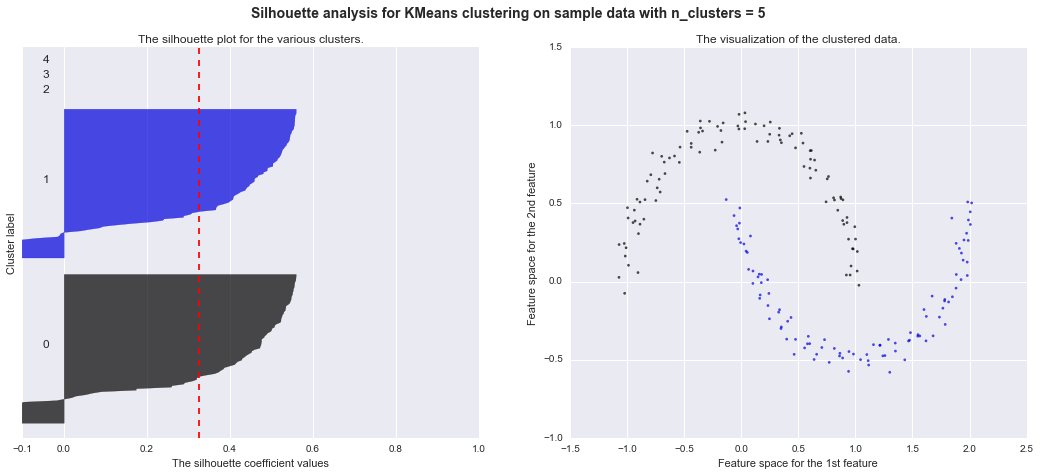

For n_clusters = 6 The average silhouette_score is : 0.325853189502


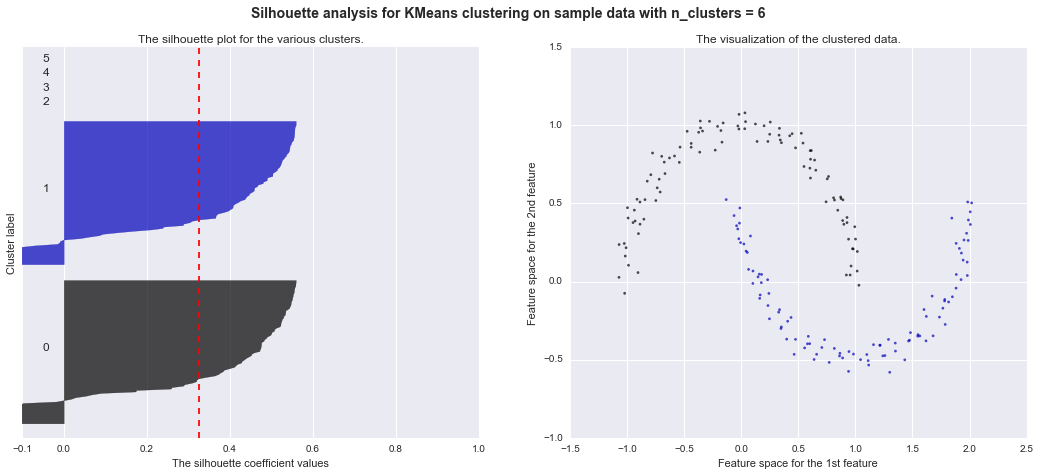

In [40]:
#See: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 
from __future__ import print_function

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distict cluster and 3 clusters placed close
# together.
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans',random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1],
               # marker='o', c="white", alpha=1, s=200)

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()